In [10]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SolveLinSys
import time
from utilities import compute_derivatives_2d, find_nearest_value
from numba import njit

In [11]:
def false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def compute_prob(μ_2_state, λ_2p_state, λ_2p_prior):
    λ_2p = np.zeros(λ_2p_state.shape[0]*μ_2_state.shape[0])
    μ_2 = np.zeros_like(λ_2p)
    π_o = np.zeros_like(λ_2p)
    for i in range(λ_2p_state.shape[0]):
        for j in range(μ_2_state.shape[0]):
            idx = i*μ_2_state.shape[0] + j
            λ_2p[idx] = λ_2p_state[i]
            μ_2[idx] = μ_2_state[j]
            π_o[idx] = 1./len(μ_2_state) * λ_2p_prior[i]
    return μ_2, λ_2p, π_o

Equation:

\begin{align}
0 = \max_e \min_{h_2} \min_{\pi_j:\sum_j^J{\pi_j}=1} &-\delta \phi(y,z_2) + \delta\eta\log e  + \frac{\partial \phi}{\partial y}(y, z_2) z_2 e\\
&+ \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho(z_2 - \sum_{j}^J \pi_j \mu_{2,j}) \right] + \left[\frac{\partial^2 \phi}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)\\
& + (\eta-1)\sum_{j}^J \pi_{j}\left(\frac{d}{d \tau}\Lambda_j(y)z_2 e\right)\\
& + \xi_a \sum_{j}^J \pi_{j} \left(\log \pi_j - \log \pi_j^o\right)
\end{align}

where

\begin{equation}
\Lambda_j(\tau)=
\begin{cases}
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2, & \tau\leq \bar{\tau} \\
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2 + \frac{\lambda_{2,j}^+}{2}(\tau-\bar{\tau})^2, & \tau > \bar{\tau}
\end{cases}
\end{equation}

FOC of $\pi_j$ gives:
$$
\pi_j \propto \exp\left(-\frac{1}{\xi_a}\left[(\eta-1)\left(\frac{d}{d \tau}\Lambda_j(z_2 y) z_2 e \right) + \frac{\partial \phi}{\partial z_2}(y, z_2)\rho \mu_{2,j} \right]\right)\pi_j^o
$$

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2)z_2 + (\eta-1)\sum_{j}^J\pi_j\frac{d}{d \tau}\Lambda_j(y)z_2}
$$

In [ ]:
def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o  = model_paras
    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])
    if v0 is None:
        v0 = -δ*η*y_mat

    d_Λ = np.array([λ_1 + λ_2*y_mat + λ_2p_j*(y_mat>λ_bar)*(y_mat-λ_bar) for λ_2p_j in λ_2p])
    d_Λ_z = d_Λ * z_mat

    π = np.ones_like(d_Λ)
    μ_2_new = np.ones_like(d_Λ)
    for i in range(π.shape[0]):
        π[i] = π_o[i]
        μ_2_new[i] = μ_2[i]
    π_o = π.copy()
    μ_2 = μ_2_new

    mean = - ρ*(z_mat-μ_2)
    std = np.sqrt(z_mat)*σ_2
    var = std**2/2.    
    e = - δ*η / ((η-1)*np.sum(π*d_Λ_z, axis=0))
    e_old = e.copy()
    
    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        log_π_ratio = -((η-1.)*d_Λ_z*e+v0_dz*ρ*μ_2)/ξ_a
        π_ratio = log_π_ratio - np.max(log_π_ratio, axis=0)
        π = np.exp(π_ratio) * π_o
        π = π/np.sum(π, axis=0)
        π[π<=0] = 1e-12

        e_new = - δ*η / (v0_dy*z_mat + (η-1)*np.sum(π*d_Λ_z, axis=0))
        e_new[e_new<=0] = 1e-12
        e = e_new * 0.5 + e_old * 0.5
        e_old = e.copy()
        
        A = np.ones_like(z_mat)*(-δ)
        B_z = np.sum(π*mean, axis=0)
        B_y = z_mat*e
        C_zz = var
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) + (η-1)*np.sum(π*d_Λ_z*e, axis=0)\
            + ξ_a*np.sum(π*(np.log(π)-np.log(π_o)), axis=0)
        res = false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    return v0, e, π

In [ ]:
# Model parameters
η = .032
ξ_a = 1./4000
δ = .01
# Z process
μ_2_mean = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/3.
# Damage setting
λ_1 = 1.7675/10000
λ_2 = 0.0022*2
λ_bar = 2.

# three damage
λ_2p_state = np.array([0., 0.0197*2, 0.3853*2])
λ_2p_prior = np.array([0.4875, 0.4875, 0.025])
μ_2_state = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.

μ_2, λ_2p, π_o = compute_prob(μ_2_state, λ_2p_state, λ_2p_prior)
pde_paras = (η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 50
z_min = np.max([μ_2_mean - 3*np.sqrt(σ_2**2*μ_2_mean/(2*ρ)), 1e-9])
z_max = μ_2_mean + 3*np.sqrt(σ_2**2*μ_2_mean/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 50
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, n_y)

In [ ]:
ϕ_grid, e_grid, π_grid = false_transient(z_grid, y_grid, model_paras=pde_paras,
                                         v0=None, ϵ=.5, tol=1e-8, max_iter=10_000)

Text(0.5, 1.0, '$h(y, z_2)$, $z_2=1.86/1000$')

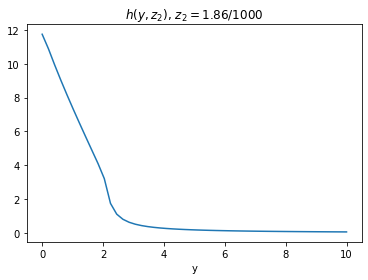

In [106]:
plt.plot(y_grid, e_grid[25])
plt.xlabel('y')
plt.title(r'$h(y, z_2)$, $z_2=1.86/1000$')
# plt.ylim(0, 1)

Text(0.5, 1.0, '$h(y, z_2)$, $z_2=1.86/1000$')

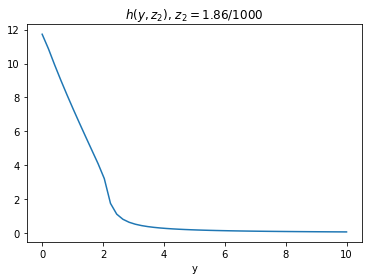

In [99]:
plt.plot(y_grid, e_grid[25])
plt.xlabel('y')
plt.title(r'$h(y, z_2)$, $z_2=1.86/1000$')
# plt.ylim(0, 1)

In [75]:
@njit
def simulation(y_grid, z_grid, e_grid, yoz_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    z = z_grid[z_loc]
    for i in range(T+1):
        Et[i] = np.interp(yoz_start*z, y_grid, e_grid[z_loc])
        yoz_start = yoz_start + Et[i]
    return Et


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [77]:
T = 100
Et = simulation(y_grid, z_grid, e_grid, yoz_start=290, z_loc=25, T=T)

Text(0.5, 0, 'Year')

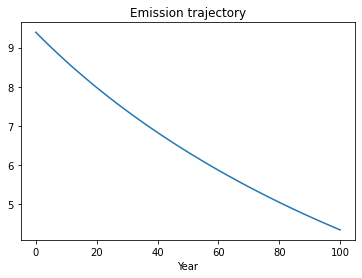

In [78]:
plt.figure()
plt.title('Emission trajectory')
plt.plot(Et)
plt.xlabel('Year')

## SCC computation

$$
SCC = ME(y, z_2) \frac{(\alpha-i^*)\exp(k-n)}{\delta(1-\eta)}
$$

In our uncertainty decompositions, we compute $ME$ in the following four steps:

i) compute
$$
ME_1(y, z_2) = (1-\eta)\left(\sum_{j=1}^J\pi_jz_2\frac{d}{d \tau}\Lambda_j (y)\right)
$$

ii) construct
$$
U(y, z_2) = (1-\eta) \left[\sum_{j=1}^J\pi_jz_2^2 \frac{d^2}{d\tau^2}\Lambda_j (y) e^*(y, z_2)\right]
$$

iii) solve
$$
0 = -\delta f + \frac{\partial f}{\partial y}e^* + \frac{\partial f}{\partial z_2}\left[-\rho(z_2 - \sum_{j}^J \pi_j\mu_{2,j})\right] + \left[\frac{\partial^2 f}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
$$

iv) then $ME_2(y, z_2)=f(y, z_2)$, and $ME(y, z_2) = ME_1(y, z_2) + ME_2(y, z_2)$